In [1]:
import numpy as np
import sympy as sp
from sympy.abc import x, y
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
from functools import reduce
from scipy.optimize import fsolve
from IPython.display import clear_output

In [2]:
def full_soln(x):
    return list(x) + [1 - sum(x[1:])]

In [3]:
#Some code that implements progress bars for long computations
#https://www.mikulskibartosz.name/how-to-display-a-progress-bar-in-jupyter-notebook/
bar_length = 20
def update_progress(progress):
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [4]:
# NE_data = dict()
# for N in range(3, 5):
#     start_time = datetime.now()
#     print("N = ", N)
#     print("Start Time: ", start_time)
    
#     p = sp.IndexedBase('p')
#     i = sp.symbols('i', cls=sp.Idx, range=(1,N))
#     Z0, c0 = sp.symbols('Z0, c0')
#     Z0 = sp.summation(p[i], (i, 1, N))**(N-1)
#     L = lambda i: lambda Q: p[i]*sp.diff(Q, p[i]).subs(p[i], 0)
#     OneMinusL = lambda i: lambda Q: Q - L(i)(Q)
#     Z = lambda i: Z0 if i==0 else reduce(lambda f,g: lambda x: f(g(x)), [OneMinusL(x) for x in range(1, i+1)])(Z0)
#     c = lambda i: Z(i-1).subs(p[i], 0)
#     func = lambda x: [sp.lambdify([c0]+[p[i] for i in range(1, N)], c(j).subs(p[N], 1-sp.summation(p[i], (i, 1, N-1))).simplify()-c0)(*x) for j in range(1, N+1)]
#     soln = full_soln(fsolve(func, [1/N for _ in range(N)]))
#     print(soln)
#     NE_data[N] = soln
#     # with open("data/NE{}.pk".format(N), 'wb') as file:
#     #     pickle.dump(soln, file)
    
#     end_time = datetime.now()
#     print("End Time: ", end_time)
#     diff = end_time - start_time
#     print("Elapsed Time: {} days {} hours {} minutes {} seconds {} milliseconds {} microseconds".format(diff.days, diff.seconds // 3600, (diff.seconds // 60) % 60, diff.seconds % 60, diff.microseconds // 1000, diff.microseconds % 1000))
#     print()

In [5]:
N = 7
p = sp.IndexedBase('p')
i,j = sp.symbols('i j', cls=sp.Idx, range=(1,N))
Z0, c0 = sp.symbols('Z0, c0')
Z0 = sp.summation(p[i], (i, 1, N))**(N-1)
L = lambda i: lambda Q: p[i]*sp.diff(Q, p[i]).subs(p[i], 0)
OneMinusL = lambda i: lambda Q: Q - L(i)(Q)
Z = lambda i: Z0 if i==0 else reduce(lambda f,g: lambda x: f(g(x)), [OneMinusL(x) for x in range(1, i+1)])(Z0)
c = lambda i: Z(i-1).subs(p[i], 0)

In [6]:
# c0 = 0.2
# ps = dict()
# for n in range(1, N):
#     func = c(n).subs(p[N], 1-sp.summation(p[j], (j, 1, N-1)))-c0
#     display(func)
#     func = func.subs(ps)
#     ps[p[n]] = sp.solve(func, p[n])[0]
#     display(func)
#     print(ps[p[n]])
# func = c(N).subs(p[1], 1-sp.summation(p[j], (j, 2, N)))-c0
# display(func)
# func = func.subs(ps)
# display(func)
# pN = sp.solve(func, p[N])
# print(pN)

In [7]:
with open("data/NE_3-11.pk", 'rb') as file:
    NE_data = pickle.load(file)

def f1(n):
    a, b, c = (0.06672678, 0.29865376, -0.79503788)
    return a + np.exp(-b*n + c)

for n in range(N, N+1):
    print("N = " + str(n))
    print("\tc0 = " + str(NE_data[n][0]))
    print("\t   ~ {}".format(f1(n)))
    for m in range(1, n+1):
        print("\tp{} = {}".format(m, NE_data[n][m]))

N = 7
	c0 = 0.12322710099769263
	   ~ 0.12254727405797092
	p1 = 0.29457468849635626
	p2 = 0.2704791356644377
	p3 = 0.22475052400170645
	p4 = 0.1407314817155909
	p5 = 0.05808757884824096
	p6 = 0.010979491995179528
	p7 = 0.0003970992784880778


In [8]:
guess = NE_data[N][0]
pm = 0.01
c0s = np.linspace((1-pm)*guess, NE_data[N-1][0], 50)
errors = []
for guess in c0s:
    ps = {c0: guess}
    derivs = dict()
    for i in range(1, N):
        ci = c(i).subs(p[N], 1 - sp.summation(p[j], (j, 1, N-1)))
        eq = ci - c0
        soln = sp.nsolve(eq.subs(ps).simplify().subs(p[i], x), 0).simplify()
        
        ps[p[i]] = soln
        
        if guess == c0s[-1]:
            pdvs = dict()
            for l in range(i):
                sub = {p[i]: y, (c0 if l==0 else p[l]): x}
                inv_sub = {v:k for k,v in sub.items()}
                pdvs[l] = sp.re(sp.idiff(eq.subs(sub), y, x).subs(inv_sub).subs(ps).simplify())

            derivs[i] = pdvs[0] + sum([derivs[k]*pdvs[k] for k in range(1, i)])
            if np.imag(derivs[i]) < 1e-10:
                derivs[i] = np.real(derivs[i])
    error = np.real(np.abs((c(N) - c0).subs(ps).simplify())**2)
    errors.append(error)
    update_progress(list(c0s).index(guess) / len(c0s))


Progress: [####################] 98.0%


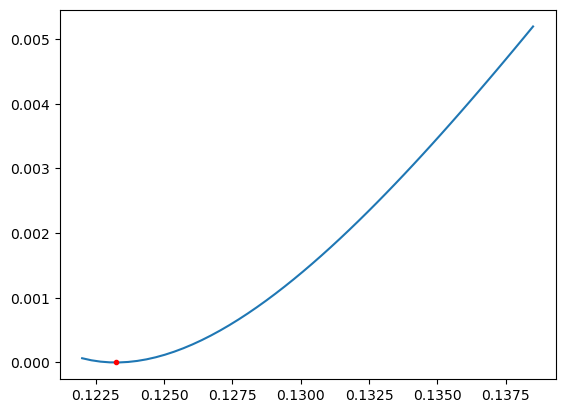

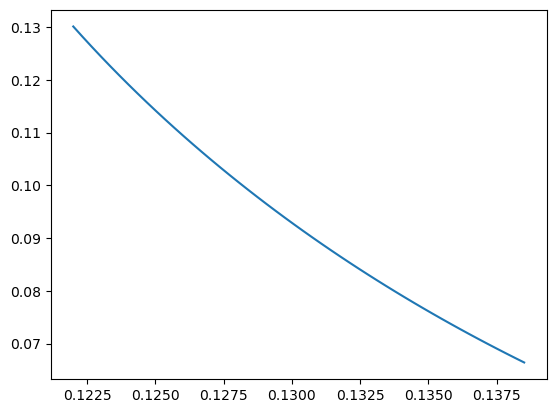

-2.56156599878853
-2.58031983027596


In [9]:
plt.plot(c0s, errors)
plt.plot([NE_data[N][0]], [0], 'r.')
plt.show()

In [10]:
m = (errors[-1] - errors[-2]) / (c0s[-1] - c0s[-2])
m

0.511741653613462

In [11]:
ps = {c0: NE_data[N-1][0]}
derivs = dict()
for i in range(1, N):
    ci = c(i).subs(p[N], 1 - sp.summation(p[j], (j, 1, N-1)))
    eq = ci - c0
    soln = sp.nsolve(eq.subs(ps).simplify().subs(p[i], x), 0.001*sp.I)
    if np.imag(soln) < 1e-10:
        soln = np.real(soln)
    
    ps[p[i]] = soln
    
    pdvs = dict()
    for l in range(i):
        sub = {p[i]: y, (c0 if l==0 else p[l]): x}
        inv_sub = {v:k for k,v in sub.items()}
        pdvs[l] = sp.idiff(eq.subs(sub), y, x).subs(inv_sub).subs(ps).simplify()
        if sp.im(pdvs[l]) < 1e-10:
            pdvs[l] = sp.re(pdvs[l])

    derivs[i] = pdvs[0] + sum([derivs[k]*pdvs[k] for k in range(1, i)])
    if np.imag(derivs[i]) < 1e-10:
        derivs[i] = np.real(derivs[i])

In [12]:
delta = (c(N) - c0).subs(ps).simplify()
error = np.real(np.abs(delta**2))
cN_prime = sp.re(sum([sp.diff(c(N), p[i]).subs(ps)*derivs[i] for i in range(1, N)]).simplify())
dE = sp.re((2*(cN_prime - 1)*delta).simplify())
dE

0.513358005607288

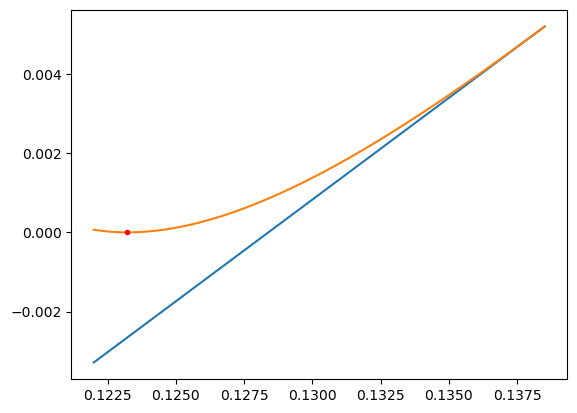

In [13]:
point = (NE_data[N-1][0], error)
b = point[1] - dE * point[0]
tangent = [dE*c + b for c in c0s]
plt.plot(c0s, tangent)
plt.plot(c0s, errors)
plt.plot([NE_data[N][0]], [0], 'r.')
plt.show()

In [14]:
cN_prime

-2.56156599878855